# Feature Analysis

In [1]:
import pandas as pd
import math
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
smear_e = 1
pt_min = 0.3
ep_min = 0.1

In [3]:
filepath = "/home/yoren/bnl/PHENIX/ee/ML/newsim/"
filenames2 = ['dalitz_100M_v0.zip','dalitz_100M_v1.zip','dalitz_100M_v2.zip','dalitz_100M_v3.zip','dalitz_100M_v4.zip']
filenames1 = ['pionminus_05_100M_v0.zip','pionminus_05_100M_v1.zip','pionminus_05_100M_v2.zip','pionminus_05_100M_v3.zip',\
              'pion_plus_05_100M_v0.zip','pion_plus_05_100M_v1.zip','pion_plus_05_100M_v2.zip','pion_plus_05_100M_v3.zip',\
              'pionminus_100M_v0.zip', 'pionminus_100M_v1.zip', 'pionminus_100M_v2.zip', 'pionminus_100M_v3.zip',\
              'pionplus_100M_v0.zip', 'pionplus_100M_v1.zip', 'pionplus_100M_v2.zip', 'pionplus_100M_v3.zip']
filenames1 = [\
              'pionminus_100M_v0.zip', 'pionminus_100M_v1.zip', 'pionminus_100M_v2.zip', 'pionminus_100M_v3.zip',\
              'pionplus_100M_v0.zip', 'pionplus_100M_v1.zip', 'pionplus_100M_v2.zip', 'pionplus_100M_v3.zip']
n_e_tot = 50e6
n_h_tot = 200e6

In [4]:
filepath = "/home/yoren/bnl/PHENIX/ee/ML/newsim/"
filenames2 = ['dalitz_100M_v0.zip']
filenames1 = ['pionminus_100M_v0.zip','pionplus_100M_v0.zip']
n_e_tot = 10e6
n_h_tot = 50e6

In [5]:
def read_csvs_from_zip(zpath):
    """Return a single DataFrame by concatenating all CSVs inside zpath."""
    dfs = []
    with zipfile.ZipFile(zpath) as z:
        # pick only CSV files (ignore folders/others)
        csv_names = [n for n in z.namelist() if n.lower().endswith(".csv") and not n.endswith("/")]
        if not csv_names:
            print(f"[warn] no CSVs found in {zpath}")
        for name in csv_names:
            with z.open(name) as f:
                dfs.append(pd.read_csv(f))
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def ensure_zip_path(filepath, base):
    """Build a .zip path even if base already has extension."""
    if base.lower().endswith(".zip"):
        return os.path.join(filepath, base)
    else:
        return os.path.join(filepath, f"{base}.zip")

# --- build data1 (phi0 = 0) ---
zpath = ensure_zip_path(filepath, filenames1[0])
data1 = read_csvs_from_zip(zpath)
data1["phi0"] = 0

for ifile in range(1, len(filenames1)):
    zpath = ensure_zip_path(filepath, filenames1[ifile])
    idata = read_csvs_from_zip(zpath)
    if not idata.empty:
        idata["phi0"] = 0
        print(idata.shape[0])
        data1 = pd.concat([data1, idata], ignore_index=True, sort=False)

# --- build data2 (phi0 = 1) ---
zpath = ensure_zip_path(filepath, filenames2[0])
data2 = read_csvs_from_zip(zpath)
data2["phi0"] = 1

for ifile in range(1, len(filenames2)):
    zpath = ensure_zip_path(filepath, filenames2[ifile])
    idata = read_csvs_from_zip(zpath)
    if not idata.empty:
        idata["phi0"] = 1
        data2 = pd.concat([data2, idata], ignore_index=True, sort=False)



2634356


In [6]:
data1['weight'] = data1['weight'] / n_h_tot * 1e8
data2['weight'] = data2['weight'] / n_e_tot * 1e8

In [7]:
data2.shape

(3293389, 16)

In [8]:
data2 = data2[ (data2['pt'] < 1.1 * data2['pt_gen']) ]

In [9]:
data2.shape

(3284241, 16)

In [ ]:
# --- merge, filter, shuffle ---
data = pd.concat([data1, data2], ignore_index=True, sort=False)
data = data[(data["pt"] > pt_min) & (data["pt"] < 25) & (data["n0"] > -1)]

In [11]:
# shuffle for ML
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
data.head()

,centrality,pt,p,ecore,n0,disp,chi2,npe0,sector,prob,emcdphi,emcdz,Q,pt_gen,weight,phi0
0,3,1.011806,1.017727,1.009397,2,2.910672,135.470642,2,2,0.331304,0.001031,0.540573,-1,1.866822,6.742452,1
1,74,0.327714,0.336966,0.219534,3,2.438032,62.547489,4,1,0.098870,-0.011145,0.861877,1,7.880408,0.000036,1
2,82,1.364760,1.365008,1.325133,5,1.891048,157.699280,9,5,0.481671,0.007879,-1.503785,1,7.826197,0.000007,1
3,6,2.163324,2.163331,2.129407,1,5.094105,144.801544,2,7,0.328073,0.000977,-0.505462,1,6.280817,0.001635,1
4,29,2.452491,2.529612,2.162387,4,1.816736,33.391674,16,6,0.948403,-0.001092,0.487213,-1,9.387427,0.000054,1


In [13]:
data['e/p']=data['ecore']/data['p']
data['chi2/npe0']=data['chi2']/data['npe0']

In [14]:
data = data[(data["e/p"] > ep_min)]

In [15]:
import numpy as np

if smear_e:
    mom_scale  = 0.981  # B-field scale
    scale   = np.array([0.988, 0.990, 0.985, 0.981, 0.980, 0.985, 1.025, 1.023])
    smear_c1 = np.array([0.055, 0.066, 0.055, 0.059, 0.057, 0.056, 0.072, 0.072])
    smear_c2 = np.array([0.011, 0.017, 0.011, 0.013, 0.012, 0.012, 0.063, 0.062])
    pt_smear = 0.025 # in %

    n = len(data)
    rand = np.random.normal(size=n)
    rand1 = np.random.normal(size=n)

    # Randomly pick ONE index for the whole sample (as in your code).
    # If you meant one per row, see the note below.
    sector = data['sector'].to_numpy()
    pt     = data['pt'].to_numpy()
    ecore = data['ecore'].to_numpy()

    # Avoid divide-by-zero in the smearing term
    eps = 1e-12
    smear_sigma = np.sqrt(smear_c1[sector]**2 + (smear_c2[sector] / np.sqrt(np.maximum(ecore, eps)))**2)
    smear_pt = 1.0 + pt_smear * rand1

    # Apply momentum scale and e/p smearing (in-place on DataFrame)
    data['pt']  = mom_scale * data['pt'] * smear_pt
    data['e/p'] = data['e/p'] / mom_scale * (1.0 + rand * smear_sigma)


In [16]:
if True:
    data['disp2'] = data['n0']-data['disp']*data['disp']/8.
    data['emcdphi'] = (data['emcdphi'].abs() < 0.02).astype(np.int8)
    data['emcdz'] = ( (data['emcdz'] - 1).abs() < 8 ).astype(np.int8)
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['chi2/npe0'] = (data['chi2/npe0'].abs() < 10).astype(np.int8)

if False:
    data['disp2'] = data['n0']-data['disp']*data['disp']/8.
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['n0*pt'] = data['n0']+4*data['pt']
    data['e/p*pt'] = 1./((data['e/p']-0.9)*(data['e/p']-0.9)+0.25)/(1.25-data['prob'])+4*data['pt']
if False:
    data['disp2'] = data.apply(lambda row: row['n0']-row['disp']**2, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    #data['e/p*prob'] = data.apply(lambda row:  1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob']), axis=1)
    #data['n0*prob'] = data.apply(lambda row: (row['n0']-2)/(1.00001-row['prob']), axis=1)
    data['centr+pt'] = data.apply(lambda row: row['centrality']/20.+row['pt']*2, axis=1)
    data['e/p*pt'] = data.apply(lambda row: row['n0']+4*row['pt'], axis=1)
    data['n0*pt'] = data.apply(lambda row: 1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob'])+4*row['pt'], axis=1)

In [17]:
data = data[( (data["e/p"] > 0.5) & (data["emcdz"] > 0) ) | (data['pt'] < 5.0)]

In [18]:
# удалим лишние колонки
#data = data.drop(columns = ['zdc','emcdphi','emcdz'])
data = data.drop(columns = ['p','pt_gen','chi2'])

In [19]:
data.head()

,centrality,pt,ecore,n0,disp,npe0,sector,prob,emcdphi,emcdz,Q,weight,phi0,e/p,chi2/npe0,disp2,centr+pt
0,3,0.973766,1.009397,2,2.910672,2,2,0.331304,1,1,-1,6.742452,1,1.062437,0,0.940998,1.098221
1,74,0.327796,0.219534,3,2.438032,4,1,0.098870,1,1,1,0.000036,1,0.541940,0,2.257000,3.807451
2,82,1.313906,1.325133,5,1.891048,9,5,0.481671,1,1,1,0.000007,1,0.969242,0,4.552992,5.826348
3,6,2.219731,2.129407,1,5.094105,2,7,0.328073,1,1,1,0.001635,1,0.973135,0,-2.243738,5.227206
4,29,2.420625,2.162387,4,1.816736,16,6,0.948403,1,1,-1,0.000054,1,0.905929,1,3.587434,7.309428


In [20]:
print(data.size, data.shape)

48822640 (2871920, 17)


In [21]:
def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    
    features = ['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2/npe0', 'Q', 'prob', 'phi0']
    
    # Define (min, max, bins) for each feature
    ranges = [
        (0, 100, 50),   # centrality
        (0, 10, 50),    # pt
        (0, 2, 40),     # e/p
        (0, 12, 24),    # n0
        (0, 10, 40),    # disp
        (0, 1, 40),     # chi2/npe0
        (-1, 1, 40),    # Q
        (0, 1, 40),     # prob
        (0, 1, 40),     # phi0
    ]
    
    for i, feature in enumerate(features):
        x, y = divmod(i, 3)
        ax_here = ax[x][y]
        xmin, xmax, nbins = ranges[i]
        
        bins = np.linspace(xmin, xmax, nbins+1)
        ax_here.hist(
            data[feature],
            bins=bins,
            color="skyblue",
            log=True,
            weights=data['weight']  # <-- apply weights
        )
        
        ax_here.set_xlim(xmin, xmax)
        ax_here.set_title(feature)
        ax_here.set_ylabel('')
    
    plt.tight_layout()
    return fig, ax

(<Figure size 1500x600 with 9 Axes>,
 array([[<Axes: title={'center': 'centrality'}>,
         <Axes: title={'center': 'pt'}>, <Axes: title={'center': 'e/p'}>],
        [<Axes: title={'center': 'n0'}>, <Axes: title={'center': 'disp'}>,
         <Axes: title={'center': 'chi2/npe0'}>],
        [<Axes: title={'center': 'Q'}>, <Axes: title={'center': 'prob'}>,
         <Axes: title={'center': 'phi0'}>]], dtype=object))

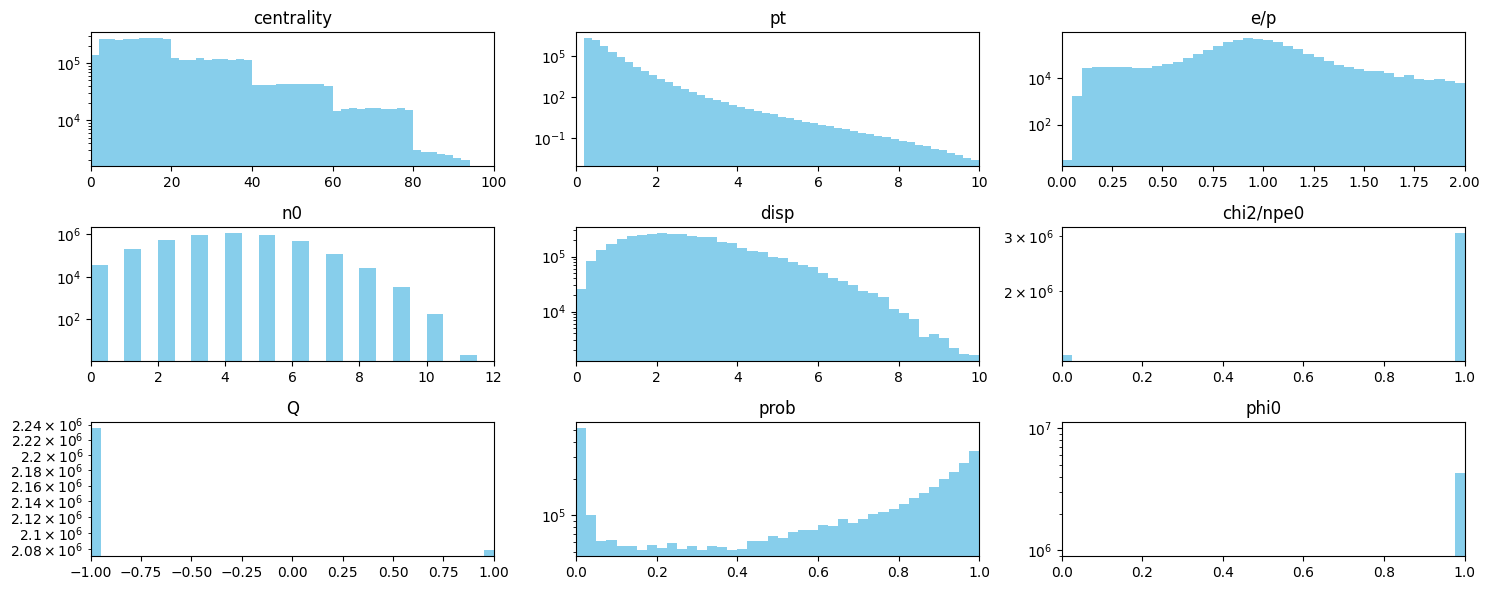

In [22]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [23]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)
    kek_data = data[cut_off_test:]
    y = data['phi0']
    w = data['weight']
    data = data.drop(columns = ['weight'])
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    w_train, w_test = w.iloc[:cut_off_test], w.iloc[cut_off_test:]

    return data_train, data_test, y_train, y_test, w_train, w_test, cut_off_val, kek_data

In [24]:
X_train_all, X_test, y_train_all, y_test, w_train_all, w_test, cut_off_val, kek_data = feature_engineering(data)

957306 1914614


In [25]:
X_test

,centrality,pt,ecore,n0,disp,npe0,sector,prob,emcdphi,emcdz,Q,e/p,chi2/npe0,disp2,centr+pt
1988766,79,1.054917,1.063966,7,2.190407,10,1,0.331853,1,1,1,1.000282,1,6.400264,5.062851
1988767,73,6.241262,7.272429,1,5.948376,1,7,0.805313,1,1,1,1.195548,0,-3.422897,42.603353
1988768,10,1.889483,1.983596,4,5.092224,10,5,0.977459,1,1,1,1.054240,1,0.758657,4.070146
1988769,74,7.782394,7.866010,4,4.327441,6,4,0.658602,1,1,1,0.977452,0,1.659157,64.265654
1988770,58,0.286948,0.238484,4,2.697038,13,3,0.363842,1,1,1,0.765838,1,3.090748,2.982339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983053,14,2.185346,2.464658,5,2.177151,24,7,0.930043,1,1,1,1.079091,1,4.407502,5.475737
2983054,22,0.462810,0.469963,3,3.019171,11,0,0.571709,1,1,1,0.956208,1,1.860576,1.314193
2983056,71,0.726542,0.605665,5,0.332263,11,4,0.414565,1,1,1,0.948091,1,4.986200,4.077863
2983057,39,0.987226,1.549713,6,2.939032,14,4,0.167328,1,1,-1,1.454849,1,4.920262,2.924614


In [26]:
X_train, X_val = X_train_all, X_train_all[cut_off_val:]
y_train, y_val = y_train_all, y_train_all[cut_off_val:]
w_train, w_val = w_train_all, w_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [27]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=2, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

In [ ]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.2],
    "min_samples_split": [0.01],
    "max_depth":[10],
    "max_features":["sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=3)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

KeyboardInterrupt: 

# Cross Validation

In [ ]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.70      0.99      0.82   3857714
           1       0.98      0.66      0.79   4788678

    accuracy                           0.81   8646392
   macro avg       0.84      0.82      0.80   8646392
weighted avg       0.86      0.81      0.80   8646392



   feature  importance
       e/p    0.212688
     disp2    0.145393
      npe0    0.122975
      disp    0.122682
        n0    0.090058
centrality    0.055087
     ecore    0.054391
      prob    0.049075
        pt    0.038018
 chi2/npe0    0.037436
     emcdz    0.033346
  centr+pt    0.020832
   emcdphi    0.015157
    sector    0.002495
         Q    0.000368


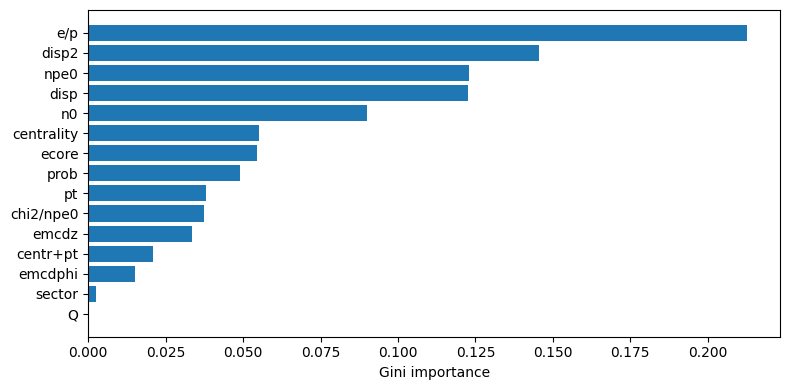

In [ ]:
# --- Feature importance (tree-based GBDT) ---
feat_names = X_train.columns
gb_best = clf.best_estimator_          # GradientBoostingClassifier
imp = gb_best.feature_importances_

import pandas as pd
fi_df = pd.DataFrame({'feature': feat_names, 'importance': imp})
fi_df = fi_df.sort_values('importance', ascending=False)
print(fi_df.to_string(index=False))

# Optional: bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.barh(fi_df.feature[::-1], fi_df.importance[::-1])
plt.xlabel("Gini importance")
plt.tight_layout()
plt.show()

if False:##more precise but slow
    # --- Permutation importance (more reliable, model-agnostic) ---
    from sklearn.inspection import permutation_importance
    pi = permutation_importance(gb_best, X_test, y_test,
                                n_repeats=5, random_state=42,
                                n_jobs=3, sample_weight=w_test)
    pi_df = pd.DataFrame({'feature': feat_names,
                          'perm_importance_mean': pi.importances_mean,
                          'perm_importance_std': pi.importances_std})
    pi_df = pi_df.sort_values('perm_importance_mean', ascending=False)
    print(pi_df.to_string(index=False))

In [ ]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.12030772478668114
roc auc: 0.9466637425521869
f1 score: 0.8523591328543519


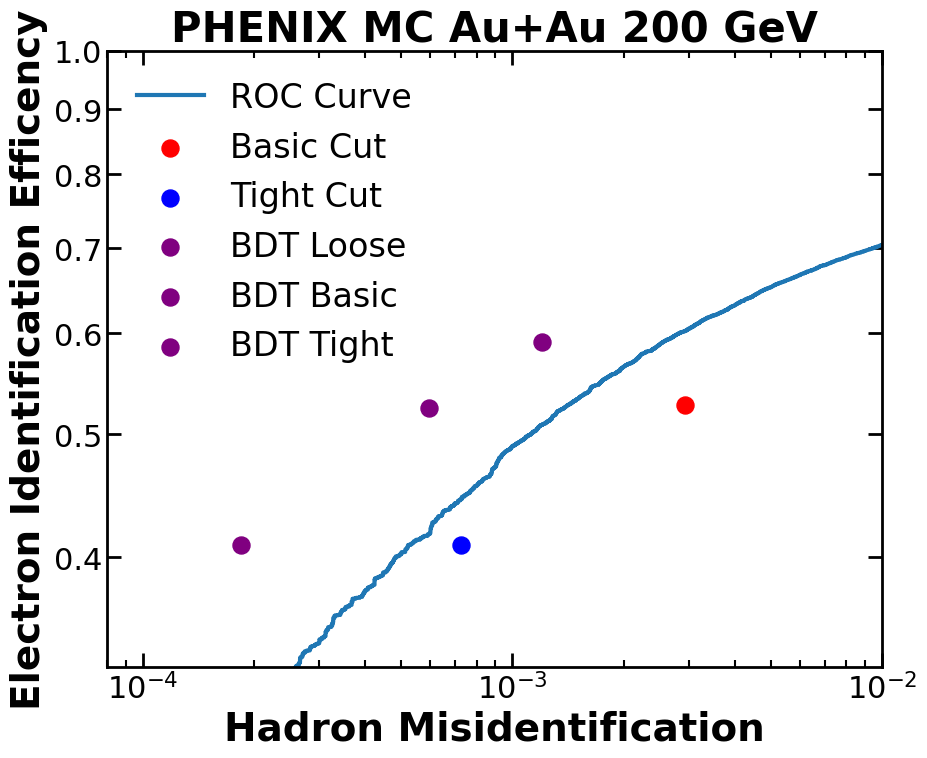

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))

# Plot ROC curve
plt.figure(figsize=(10, 8))

rej = 25/2
eff = 0.8

fpr = fpr / rej
tpr = tpr *eff
# Plot curves with increased line width
plt.plot(fpr, tpr, label='ROC Curve', linewidth=3)
#plt.plot(fpr, fpr, label='Random Guess', linestyle='--', linewidth=3)

# Add larger points to the plot  # Increased size with `s`
plt.scatter(1/1.5/rej*0.055, eff*0.659, color='red', label='Basic Cut', s=150, zorder=5)
plt.scatter(1/1.5/rej*0.0136, eff*0.511, color='blue', label='Tight Cut', s=150, zorder=5)
plt.scatter(1/rej*0.0150, eff*0.738, color='purple', label='BDT Loose', s=150, zorder=5)
plt.scatter(1/rej*0.00745, eff*0.655, color='purple', label='BDT Basic', s=150, zorder=5)
plt.scatter(1/rej*0.0023, eff*0.511, color='purple', label='BDT Tight', s=150, zorder=5)

# Set both axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set the same range for both axes
plt.xlim(1e-3/rej, 1/100)
plt.ylim(0.41*eff, 1*eff)

# Customize y-axis ticks explicitly
y_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(y_ticks, fontsize=22)

# Disable scientific notation on the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)

# Enable minor ticks and customize tick size
plt.minorticks_on()
ax.tick_params(axis='both', which='major', length=10, width=2, labelsize=22, direction='in', top=True, right=True)  # Major ticks
ax.tick_params(axis='both', which='minor', length=5, width=1.5, direction='in', top=True, right=True)  # Minor ticks

# Add labels with larger font size
plt.xlabel("Hadron Misidentification", fontsize=28, fontweight='bold')
plt.ylabel("Electron Identification Efficency", fontsize=28, fontweight='bold')
plt.xticks(fontsize=22)
plt.title('PHENIX MC Au+Au 200 GeV', fontsize=30, fontweight='bold')

# Customize legend with larger font size and no box
plt.legend(fontsize=24, loc='upper left', frameon=False)

# Thicker plot frame
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Save the plot with a transparent background
plt.savefig("output/roc_auc_curve_new.pdf", bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

log loss: 0.12030772478668114
roc auc: 0.9466637425521869
f1 score: 0.8523591328543519


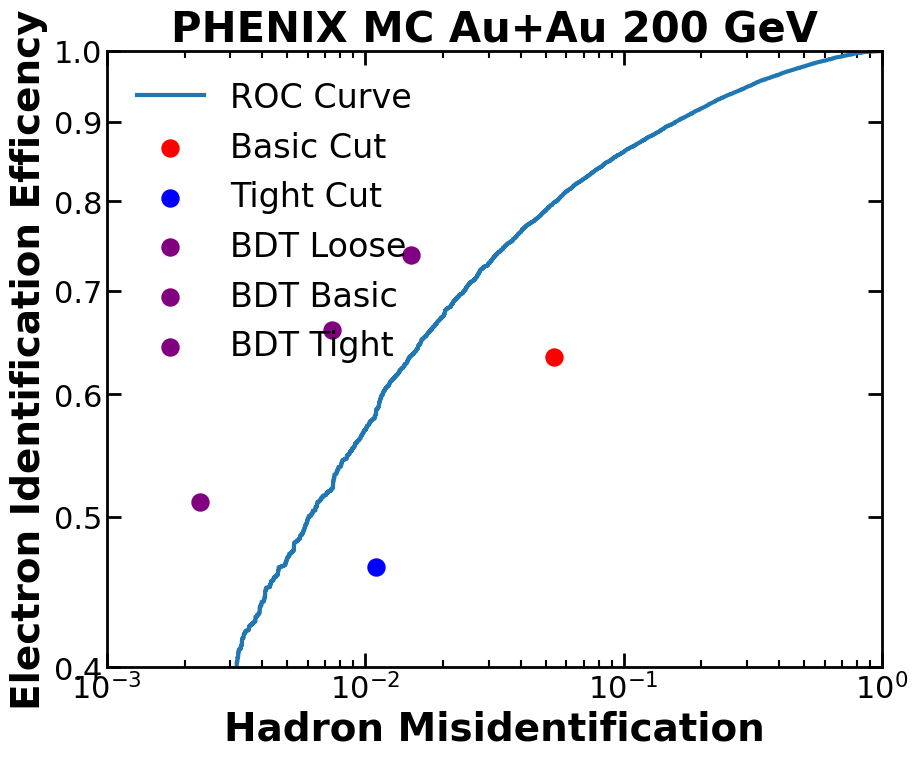

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))

# Plot ROC curve
plt.figure(figsize=(10, 8))

rej = 1
eff = 1

fpr = fpr / rej
tpr = tpr *eff
# Plot curves with increased line width
plt.plot(fpr, tpr, label='ROC Curve', linewidth=3)
#plt.plot(fpr, fpr, label='Random Guess', linestyle='--', linewidth=3)

# Add larger points to the plot  # Increased size with `s`
plt.scatter(1/rej*0.054, eff*0.634, color='red', label='Basic Cut', s=150, zorder=5)
plt.scatter(1/rej*0.011, eff*0.464, color='blue', label='Tight Cut', s=150, zorder=5)
plt.scatter(1/rej*0.0150, eff*0.738, color='purple', label='BDT Loose', s=150, zorder=5)
plt.scatter(1/rej*0.00745, eff*0.66, color='purple', label='BDT Basic', s=150, zorder=5)
plt.scatter(1/rej*0.0023, eff*0.511, color='purple', label='BDT Tight', s=150, zorder=5)

# Set both axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set the same range for both axes
plt.xlim(1e-3/rej, 1/rej/rej**0.5)
plt.ylim(0.41*eff, 1*eff)

# Customize y-axis ticks explicitly
y_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(y_ticks, fontsize=22)

# Disable scientific notation on the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)

# Enable minor ticks and customize tick size
plt.minorticks_on()
ax.tick_params(axis='both', which='major', length=10, width=2, labelsize=22, direction='in', top=True, right=True)  # Major ticks
ax.tick_params(axis='both', which='minor', length=5, width=1.5, direction='in', top=True, right=True)  # Minor ticks

# Add labels with larger font size
plt.xlabel("Hadron Misidentification", fontsize=28, fontweight='bold')
plt.ylabel("Electron Identification Efficency", fontsize=28, fontweight='bold')
plt.xticks(fontsize=22)
plt.title('PHENIX MC Au+Au 200 GeV', fontsize=30, fontweight='bold')

# Customize legend with larger font size and no box
plt.legend(fontsize=24, loc='upper left', frameon=False)

# Thicker plot frame
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Save the plot with a transparent background
plt.savefig("output/roc_auc_curve_new_centr.pdf", bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

In [ ]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.6873394272034913


In [ ]:
i = 300000
print(round(fpr[i],3),round(tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
print(fpr[i]/tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.002 0.3528
0.6190123827467647 0.0021747309248961997 0.35280171529181575
0.0061641733320298535


In [ ]:
print(sum(predicted),len(predicted))

3212884 8646392


In [ ]:
#kek_data = data
#kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(X_test)
print(proba_loc[0][1])

0.0894309111574227


In [ ]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 100, 0, 10, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 100, 0, 10, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 100, 0, 10, 10, 0, 100)
e_pt_hist_TC = root.TH2D("e_pt_hist_TC", "e_pt_hist_TC", 100, 0, 10, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 100, 0, 10, 10, 0, 100)
h_pt_hist_TC = root.TH2D("h_pt_hist_TC", "h_pt_hist_TC", 100, 0, 10, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 100, 0, 10, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 100, 0, 10, 10, 0, 100)

In [ ]:
mycute,mycuth,tcute,tcuth, AIcute, AIcuth = 0, 0, 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = kek_data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>10000000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2/npe0'], row['n0'], row['prob'], row['phi0']
    w = row['weight']/1e8
    if pt<pt_min or centrality<0: continue
    if phi0: e_pt_hist_NC.Fill(pt,centrality,w)
    else:    h_pt_hist_NC.Fill(pt,centrality,w)
    if ep>0.8 and n0>=2 and disp <5 and chi2<1: 
        if phi0: 
            mycute+=w
            e_pt_hist_SC.Fill(pt,centrality,w)
        else: 
            mycuth+=w
            h_pt_hist_SC.Fill(pt,centrality,w)

    if ep>0.8 and n0>=2 + disp**2/8 and disp <4 and prob>0.01 and chi2<1: 
        if phi0: 
            tcute+=w
            e_pt_hist_TC.Fill(pt,centrality,w)
        else: 
            tcuth+=w
            h_pt_hist_TC.Fill(pt,centrality,w)
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: 
            AIcute+=w
            e_pt_hist_AI.Fill(pt,centrality,w)
        else: 
            AIcuth+=w
            h_pt_hist_AI.Fill(pt,centrality,w)
    if phi0: norm_e+=w
    else: norm_h+=w
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [ ]:
print(norm_e, norm_h, round(mycute/norm_e,3),round(mycuth/norm_h,3),round(tcute/norm_e,3),round(tcuth/norm_h,4), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i],3),round(tpr[i],3))

0.014326401586476845 0.4268926018287963 0.147 0.036 0.064 0.0049 0.353 0.002 0.006 0.002 0.353


In [ ]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h), counter)

40.33 2.405 0.06 4995 8646391


In [ ]:
%run input/Format.ipynb
%jsroot on

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [ ]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMinimum(2e-11)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw("Hist")
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same H")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_s,"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw("H")

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2e-11)
    projh.Draw("Hist")
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same H")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_sd,"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

0.0004014357725971359 2.8276738683306276e-06


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [ ]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,3)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_new_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_new_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_new_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw("Hist")
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_new_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same H")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    #legends[-1].SetNColumns(2)
    legends[-1].AddEntry(proj,"e tot","l")
    legends[-1].AddEntry(phoj_s,"e std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}",2*icentr+1,2*icentr+2),"e bdt","l")
    legends[-1].Draw("H")

    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_new_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_new_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(6)
    h_pt_hist_SC.SetLineColor(3)
    h_pt_hist_AI.SetLineColor(7)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_new_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=6,  Lwidth=3,  Lcolor=6,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.Draw("Hist same")
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_new_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same H")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")
    legends[-1].AddEntry(projh,"h tot","l")
    legends[-1].AddEntry(phoj_sd,"h std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}",2*icentr+1,2*icentr+2),"h bdt","l")
    legends[-1].Draw()

    proj.SetMaximum(max(proj.GetMaximum(),projh.GetMaximum())*2)
    proj.SetMinimum(2e-12)


c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

0.0004014357725971359 2.8276738683306276e-06


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [ ]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [ ]:
import pickle
with open('output/bdtasdfs.pkl','wb') as f:
    pickle.dump(clf,f)

#print(clf.predict(X_test[0:10]))

In [ ]:
import pickle
# load
with open('output/bdtasdfs.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(X_test[0:10]))

[0 0 1 0 0 1 0 0 0 1]


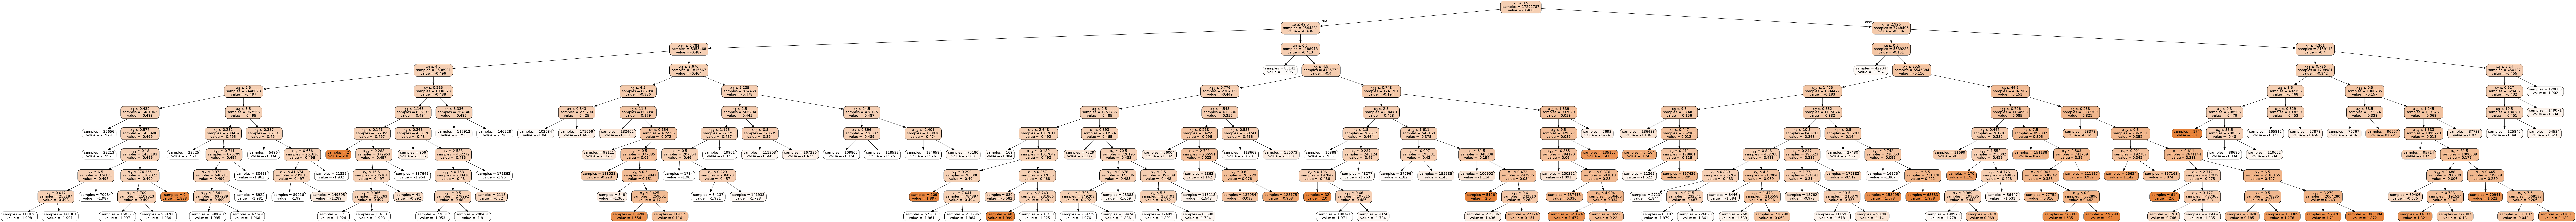

In [ ]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [ ]:
clf2.predict(X_test[0:100])

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1])

In [ ]:
clf2.predict_proba(X_test[0:100])

array([[0.91056909, 0.08943091],
       [0.92807608, 0.07192392],
       [0.4135354 , 0.5864646 ],
       [0.93516167, 0.06483833],
       [0.92947137, 0.07052863],
       [0.17270837, 0.82729163],
       [0.8365444 , 0.1634556 ],
       [0.92203912, 0.07796088],
       [0.92944954, 0.07055046],
       [0.2499492 , 0.7500508 ],
       [0.15678806, 0.84321194],
       [0.82282406, 0.17717594],
       [0.82567525, 0.17432475],
       [0.9295171 , 0.0704829 ],
       [0.12608338, 0.87391662],
       [0.40131313, 0.59868687],
       [0.08785577, 0.91214423],
       [0.82636917, 0.17363083],
       [0.89719031, 0.10280969],
       [0.79505544, 0.20494456],
       [0.93280822, 0.06719178],
       [0.10845027, 0.89154973],
       [0.08997656, 0.91002344],
       [0.84004163, 0.15995837],
       [0.77787094, 0.22212906],
       [0.30023187, 0.69976813],
       [0.89248338, 0.10751662],
       [0.39209256, 0.60790744],
       [0.92669404, 0.07330596],
       [0.93186954, 0.06813046],
       [0.

In [ ]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 0.01, 'n_estimators': 10}


In [ ]:
clf2.best_estimator_.predict_proba(X_test[9:20])

array([[0.2499492 , 0.7500508 ],
       [0.15678806, 0.84321194],
       [0.82282406, 0.17717594],
       [0.82567525, 0.17432475],
       [0.9295171 , 0.0704829 ],
       [0.12608338, 0.87391662],
       [0.40131313, 0.59868687],
       [0.08785577, 0.91214423],
       [0.82636917, 0.17363083],
       [0.89719031, 0.10280969],
       [0.79505544, 0.20494456]])

In [ ]:
y = clf2.best_estimator_[0, 0].predict(X_test[9:19].values.tolist())*0
#y = gb_clf.decision_function(X_test[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(X_test[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(X_test[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[ 1.09888323  1.68232334 -1.53559917 -1.55528162 -2.579295    1.93604152
  0.39999673  2.34010162 -1.56011023 -2.16638841]
[-3.21195649 -2.46508064 -2.62300782 -2.62300782 -3.54405406 -3.34924374
 -2.46508064 -2.32779339 -3.50294646 -2.62300782 -2.32779339]
[0.7500508  0.84321194 0.17717594 0.17432475 0.0704829  0.87391662
 0.59868687 0.91214423 0.17363083 0.10280969]


In [ ]:
best_gbc = clf2.best_estimator_

In [ ]:
n_estim = best_gbc.n_estimators

In [ ]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(X_test[9:19]))
arr = clf2.decision_function(X_test[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(X_test[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[ 1.09888323  1.68232334 -1.53559917 -1.55528162 -2.579295    1.93604152
  0.39999673  2.34010162 -1.56011023 -2.16638841]
[0.7500508  0.84321194 0.17717594 0.17432475 0.0704829  0.87391662
 0.59868687 0.91214423 0.17363083 0.10280969]
0.2


In [ ]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(X_test[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(X_test[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [ ]:
print(log_odds_predictions)

[[-0.032542558340128654, 1.8718455985799267, -1.3354431763136225, -1.114009319309272, -1.998486760755824, 1.5218902776214043, -0.18033406586117465, 1.8718455985799267, -1.722972114395607, -1.953377046012529], [-0.526077598052135, 1.365927867225331, -1.7124220714364724, -1.462087153312646, -1.628678423487368, 1.4765514966248545, 1.365927867225331, 1.365927867225331, -1.272047748314123, -1.5591586226641736], [1.147343972790211, 1.406423795740213, -0.5187906958383633, -0.583626140505473, -1.297537594685993, 0.6224065177426105, 0.14171073498409054, 1.406423795740213, -0.9022012206362855, -1.1123744700105602], [0.1854465924583297, 0.2907142610292207, -1.3526900894402898, -1.2822220526394048, -1.3130427351652763, 0.1854465924583297, -0.4777736824703448, 1.444816228751856, -1.334230183412556, -1.0369194013281182], [1.5516421746232105, 1.0593011026430432, -1.2374915312412742, -1.1683207008442305, -1.2614109894640093, 0.7885714816517269, -0.3960754578978228, 1.2106751654756172, -0.3102818435172

In [ ]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(X_test[9:19]))

0.2 1.0988832346284154
[ 1.09888323  1.68232334 -1.53559917 -1.55528162 -2.579295    1.93604152
  0.39999673  2.34010162 -1.56011023 -2.16638841]


In [ ]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(X_test[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

10
1
[[-0.032542558340128654, -0.526077598052135, 1.147343972790211, 0.1854465924583297, 1.5516421746232105, 1.0181037470027205, 0.8525606137178379, 1.2473452736201087, 0.584990569827762, -0.534396614505841], [1.8718455985799267, 1.365927867225331, 1.406423795740213, 0.2907142610292207, 1.0593011026430432, 0.22502609517478042, 0.8525606137178379, 0.45955451499518873, 0.549692634865949, 0.33057023631362986], [-1.3354431763136225, -1.7124220714364724, -0.5187906958383633, -1.3526900894402898, -1.2374915312412742, -1.101448245239137, -1.0899889004564194, 0.9661849309578949, -0.7065863835245652, 0.4106802904165015], [-1.114009319309272, -1.462087153312646, -0.583626140505473, -1.2822220526394048, -1.1683207008442305, -0.902958057472737, -0.33622564940836214, 0.9661849309578949, -0.9864412855980059, -0.9067026758817007], [-1.998486760755824, -1.628678423487368, -1.297537594685993, -1.3130427351652763, -1.2614109894640093, -1.1565320006753272, -1.1242276254457555, -1.0844518396834433, -1.125

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [ ]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
#print(f"double mytree{list(X_test.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[3] > 3.5) if (x[4] <= 2.92612) if (x[9] > 0.5) if (x[0] > 25.5) if (x[0] > 44.5) if (x[2] > 0.23785) if (x[12] > 0.5) if (x[11] > 0.61066) if (x[5] > 6.5) if (x[14] > 3.27926)   return 1.8718455985799267;  // | based on 1,806,304 samples
        if  (x[3] <= 3.5) if (x[0] <= 49.5) if (x[11] <= 0.78313) if (x[5] <= 4.5) if (x[5] <= 2.5) if (x[1] > 0.43201) if (x[1] > 0.57744) if (x[11] > 0.18026) if (x[4] <= 374.35489) if (x[1] > 2.70867)   return -1.9836816304571387;  // | based on 958,788 samples
        if  (x[3] <= 3.5) if (x[0] <= 49.5) if (x[11] <= 0.78313) if (x[5] <= 4.5) if (x[5] > 2.5) if (x[6] <= 5.5) if (x[2] > 0.28171) if (x[11] <= 0.71127) if (x[7] <= 0.97318) if (x[13] <= 2.54062)   return -1.9953046923990607;  // | based on 590,040 samples
        if  (x[3] <= 3.5) if (x[0] > 49.5) if (x[9] > 0.5) if (x[5] <= 4.5) if (x[11] <= 0.776) if (x[5] <= 2.5) if (x[14] > 2.64776) if (x[13] <= -0.18934) if (x[1] > 0.29926) if (x[4] <= 7.

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [ ]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[3] > 3.5) and (x[4] <= 2.92612) and (x[9] > 0.5) and (x[0] > 25.5) and (x[0] > 44.5) and (x[2] > 0.23785) and (x[12] > 0.5) and (x[11] > 0.61066) and (x[5] > 6.5) and (x[14] > 3.27926) :  return 1.8718455985799267  # | based on 1,806,304 samples
        if (x[3] <= 3.5) and (x[0] <= 49.5) and (x[11] <= 0.78313) and (x[5] <= 4.5) and (x[5] <= 2.5) and (x[1] > 0.43201) and (x[1] > 0.57744) and (x[11] > 0.18026) and (x[4] <= 374.35489) and (x[1] > 2.70867) :  return -1.9836816304571387  # | based on 958,788 samples
        if (x[3] <= 3.5) and (x[0] <= 49.5) and (x[11] <= 0.78313) and (x[5] <= 4.5) and (x[5] > 2.5) and (x[6] <= 5.5) and (x[2] > 0.28171) and (x[11] <= 0.71127) and (x[7] <= 0.97318) and (x[13] <= 2.54062) :  return -1.9953046923990607  # | based on 590,040 samples
        if (x[3] <= 3.5) and (x[0] > 49.5) and (x[9] > 0.5) and (x[5] <= 4.5) and (x[11] <= 0.776) and (x[5] <= 2.5) and (x[14] > 2.64776) and (x[13] <=

In [ ]:
def mytree(x,y):
    return 0

In [ ]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [ ]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(X_test[9:19].values.tolist())
print(y)

myf = [mytree(iestim, X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-0.53439661  0.33057024  0.41068029 -0.90670268 -0.90670268  0.8076827
  0.70925884  0.88046416  0.15650838 -0.90670268]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.2499492  0.7500508 ]
 [0.15678806 0.84321194]
 [0.82282406 0.17717594]
 [0.82567525 0.17432475]
 [0.9295171  0.0704829 ]
 [0.12608338 0.87391662]
 [0.40131313 0.59868687]
 [0.08785577 0.91214423]
 [0.82636917 0.17363083]
 [0.89719031 0.10280969]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
input_x = [ X_test[9:19].values.tolist()[0][i] for i in range(len(X_test[9:19].values.tolist()[0])) ]
print(input_x)

[92.0, 0.398070170652537, 0.3822766542434692, 3.0, 1.8919944763183596, 3.0, 6.0, 0.7755911946296692, 1.0, 1.0, 1.0, 0.8796537680447266, 1.0, 2.552544612697602, 4.75845986076334]


In [ ]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
y = [y[i][1] for i in range(len(y))]
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[0.7500507989263056, 0.8432119351198097, 0.17717593626367956, 0.17432474663208433, 0.07048290477419909, 0.8739166177499585, 0.5986868733823214, 0.9121442287923883, 0.17363083014589628, 0.1028096880472475]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
column_headers = list(X_test.columns.values)
print(column_headers)
print(len(column_headers))

['centrality', 'pt', 'ecore', 'n0', 'disp', 'npe0', 'sector', 'prob', 'emcdphi', 'emcdz', 'Q', 'e/p', 'chi2/npe0', 'disp2', 'centr+pt']
15
